In [1]:
%matplotlib inline
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("data/22800_SELECT_t___FROM_data_data_t.csv",header=None,index_col=0)
df = df.rename(columns={0:"no", 1: "CAPTDATA", 2: "CAPTIMAGE",3: "timestamp"})

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22800 entries, 1 to 22815
Data columns (total 3 columns):
CAPTDATA     22800 non-null object
CAPTIMAGE    22800 non-null object
timestamp    22800 non-null object
dtypes: object(3)
memory usage: 712.5+ KB


In [3]:
df.sample(5)

,CAPTDATA,CAPTIMAGE,timestamp
0,,,
1662,/B8atneD5qTSWJQUyov4AA==,0x89504E470D0A1A0A0000000D49484452000001180000...,2019-11-03 16:11:15
6400,FOiiBF2wYSqZUrwd46qouw==,0x89504E470D0A1A0A0000000D49484452000001180000...,2019-11-03 16:23:00
18385,HHhuuO5FvoyluaN0WfPxgA==,0x89504E470D0A1A0A0000000D49484452000001180000...,2019-11-03 16:48:43
14615,IXFiPEqueMnl4bNf/mnoHQ==,0x89504E470D0A1A0A0000000D49484452000001180000...,2019-11-03 16:40:32
22137,0xU8vGerf3r2VRvI8YEaig==,0x89504E470D0A1A0A0000000D49484452000001180000...,2019-11-03 16:56:51


In [4]:
def alpha_to_gray(img):
    alpha_channel = img[:, :, 3]
    _, mask = cv2.threshold(alpha_channel, 128, 255, cv2.THRESH_BINARY)  # binarize mask
    color = img[:, :, :3]
    img = cv2.bitwise_not(cv2.bitwise_not(color, mask=mask))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:
def preprocess(data):
    data = bytes.fromhex(data[2:])
    img = cv2.imdecode( np.asarray(bytearray(data), dtype=np.uint8), cv2.IMREAD_UNCHANGED )
    img = alpha_to_gray(img)
    kernel = np.ones((3, 3), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    img = cv2.medianBlur(img, 3)
    kernel = np.ones((4, 4), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
#     plt.imshow(img)
    return img

In [6]:
df["IMAGE"] = df["CAPTIMAGE"].apply(preprocess)

In [7]:
def bounding(gray):
#     data = bytes.fromhex(df["CAPTIMAGE"][1][2:])
#     image = cv2.imdecode( np.asarray(bytearray(data), dtype=np.uint8), cv2.IMREAD_UNCHANGED )

#     alpha_channel = image[:, :, 3]
#     _, mask = cv2.threshold(alpha_channel, 128, 255, cv2.THRESH_BINARY)  # binarize mask
#     color = image[:, :, :3]
#     src = cv2.bitwise_not(cv2.bitwise_not(color, mask=mask))

    ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    contours, hierachy = cv2.findContours(binary, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)

    ans = []
    for h, tcnt in enumerate(contours):
        x,y,w,h = cv2.boundingRect(tcnt)
        if h < 20:
            continue
        if 50 < w < 100: # 2개가 붙어 있는 경우
            ans.append([x,y,w//2+10,h])
            ans.append([x+(w//2)-10,y,w//2+10,h])
            continue
#         cv2.rectangle(src,(x,y),(x+w,y+h),(255,0,0),1)
        ans.append([x,y,w,h])
    return ans
    # cv2.destroyAllWindows()

In [8]:
df["bounding"] = df["IMAGE"].apply(bounding)

In [9]:
def draw_bounding(idx):
    CAPTIMAGE = df["CAPTIMAGE"][idx]
    bounding = df["bounding"][idx]
    
    data = bytes.fromhex(CAPTIMAGE[2:])
    image = cv2.imdecode( np.asarray(bytearray(data), dtype=np.uint8), cv2.IMREAD_UNCHANGED )

    alpha_channel = image[:, :, 3]
    _, mask = cv2.threshold(alpha_channel, 128, 255, cv2.THRESH_BINARY)  # binarize mask
    color = image[:, :, :3]
    src = cv2.bitwise_not(cv2.bitwise_not(color, mask=mask))

    for x,y,w,h in bounding:
#         print(x,y,w,h)
        cv2.rectangle(src,(x,y),(x+w,y+h),(255,0,0),1)
    return src

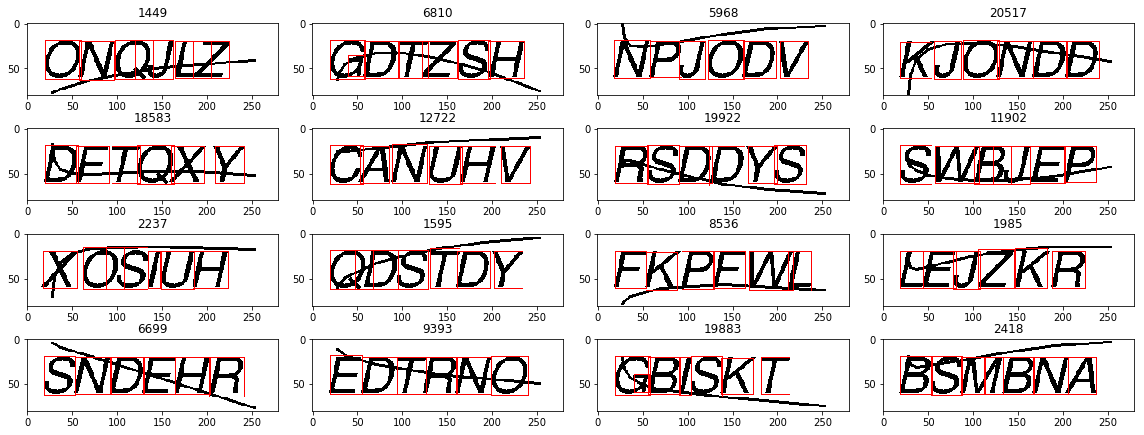

In [10]:
import random

nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches((16, 6)) 
for i in range(nrows):
    for j in range(ncols):
        idx = random.randrange(20,22800)
        axes[i][j].set_title(str(idx))
        axes[i][j].imshow(draw_bounding(idx))
fig.tight_layout()
plt.savefig('sample.png')
plt.show()